**Problem Statement**

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.



Import all the important Python libraries

In [1]:
##Import python library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
import PIL
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Mount Drive

In [2]:
#connect to gdrive and mount it
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Load Dataset

In [3]:
# get the train & test folder path location from gdrive
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test  = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [4]:
#Train folder
dir_train = os.listdir(data_dir_train)
dir_train.sort()
dir_train

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [5]:
#Test Folder
dir_test = os.listdir(data_dir_test)
dir_test.sort()
dir_test

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [6]:
#both test & train have same folders (disease folder ), now check the no. of datapoints in each folder
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Create DataSet .Define some parameters

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#Generates a tf.data.Dataset from the image files in the directory.
train_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='training',
            )##todo

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#Generates a tf.data.Dataset from the image files in the directory.
val_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='validation',
            )##todo

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Visualize the data

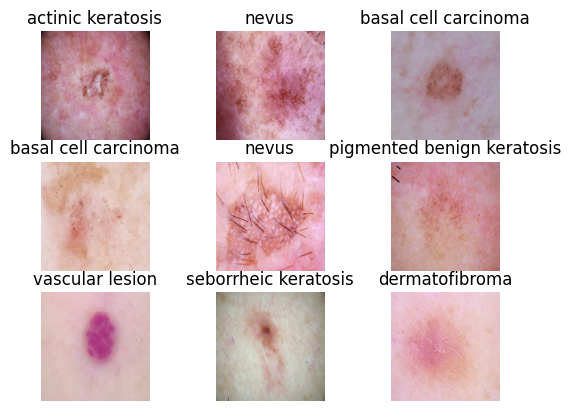

In [11]:
### Data visualization of 1 dataPoint with all 9 instances
import matplotlib.pyplot as plt
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[i]])
        plt.axis('off')

The image_batch is a tensor of the shape (32, 180, 180, 3). This is batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.


In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Create the model**
 Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [13]:
#The Keras sequence class helps create a layer cluster that is linearly stacked into a tf. keras. Model.
num_class = 9
model = tf.keras.Sequential([
    layers.Rescaling(scale = 1./255, input_shape = (180,180,3)),
    layers.Conv2D(16,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_class)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Compile the model
Choose an appropirate optimiser and loss function for model training

In [14]:
#loss: Sparse Categorical Crossentropy Calculates the crossentropy loss between labels and predictions.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

Train the Model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 272s 3s/step - accuracy: 0.2245 - loss: 2.1633 - val_accuracy: 0.3423 - val_loss: 1.9305
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3259 - loss: 1.8715 - val_accuracy: 0.4183 - val_loss: 1.6804
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4601 - loss: 1.6087 - val_accuracy: 0.4877 - val_loss: 1.5426
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4633 - loss: 1.4952 - val_accuracy: 0.4966 - val_loss: 1.4581
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5222 - loss: 1.3453 - val_accuracy: 0.5235 - val_loss: 1.3747
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5585 - loss: 1.2497 - val_accuracy: 0.5459 - val_loss: 1.3511
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5918 - loss: 1.1572 - val_accuracy: 0.5526 - val_loss: 1.3318
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6258 - loss: 1.0594 - val_accuracy: 0.4922 - v

Visualizing Training Results

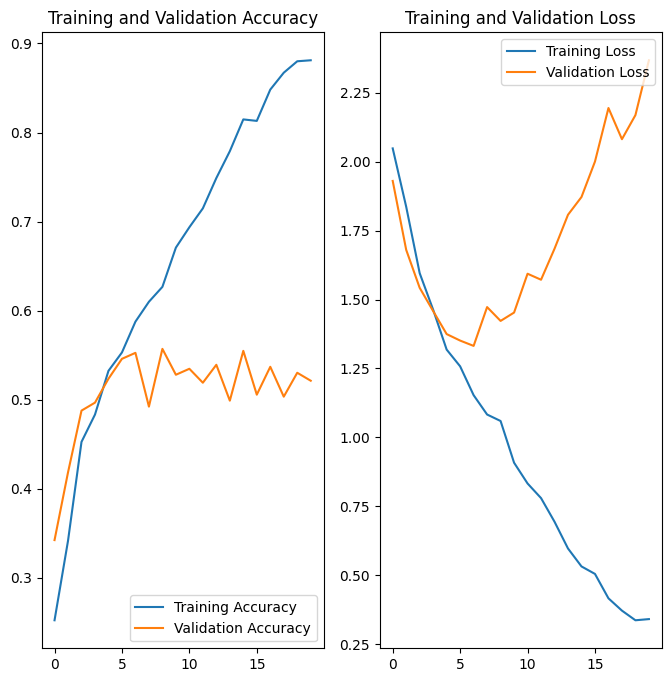

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Findings:-
The above model is clearly the case of overfitting and the model doesn't seem to be learning anything from the dataset.
   (1) Training accuracy is very high, while validation accuracy is around 50%.
   (2) The loss on the training set decreases after each epoch, but in the case of the validation set, it climbs back again after the 5th epoch.

Instead of generalizing and learning real features the model memorized the data

In [18]:
# After  analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=(0.2,0.3), width_factor=(0.2,0.3))
])

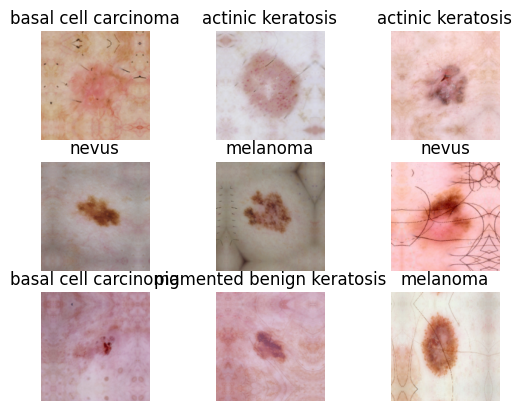

In [19]:
# Visualize how your augmentation strategy works for one instance of training image.
for img, labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(data_augmentation(img)[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Create the model, compile and train the model

In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
#The Keras sequence class helps create a layer cluster that is linearly stacked into a tf. keras. Model.

num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

Compiling the model

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

Training the model

In [22]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.1895 - loss: 2.2000 - val_accuracy: 0.2394 - val_loss: 1.9921
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.2642 - loss: 1.9957 - val_accuracy: 0.2975 - val_loss: 1.8949
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.3018 - loss: 1.8383 - val_accuracy: 0.2908 - val_loss: 1.9108
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3445 - loss: 1.7872 - val_accuracy: 0.4541 - val_loss: 1.5813
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4617 - loss: 1.5227 - val_accuracy: 0.4765 - val_loss: 1.5680
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4547 - loss: 1.5050 - val_accuracy: 0.4787 - val_loss: 1.4442
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.4668 - loss: 1.4917 - val_accuracy: 0.4810 - val_loss: 1.4898
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.4960 - loss: 1.4463 - val_accuracy: 0.5324 - v

Visualize Results

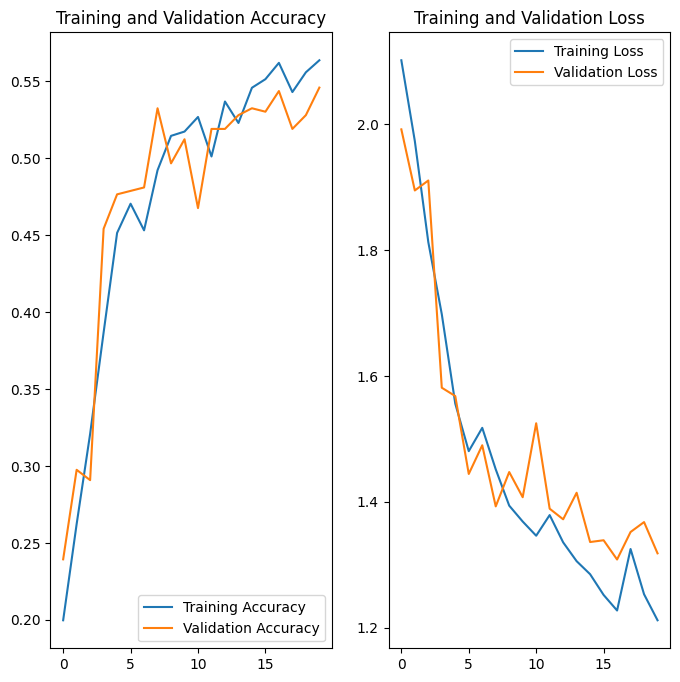

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Findings:-
In the above model use of data augmentation and dropout layer reduced the problem of overfitting.

The accuracy of the model has greatly increased along with the synchronization of the verification accuracy. The loss function is synchronously exhausted for the training and validation data.

Find the distribution of classes in the training dataset.

In [24]:
path_list=[]
lesion_list=[]

In [25]:
for i in class_names:
  for j in data_dir_train.glob(i+'/*.jpg'):
    path_list.append(str(j))
    lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
1,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
2,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
3,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
4,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,vascular lesion
2235,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,vascular lesion
2236,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,vascular lesion
2237,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,vascular lesion


<BarContainer object of 9 artists>

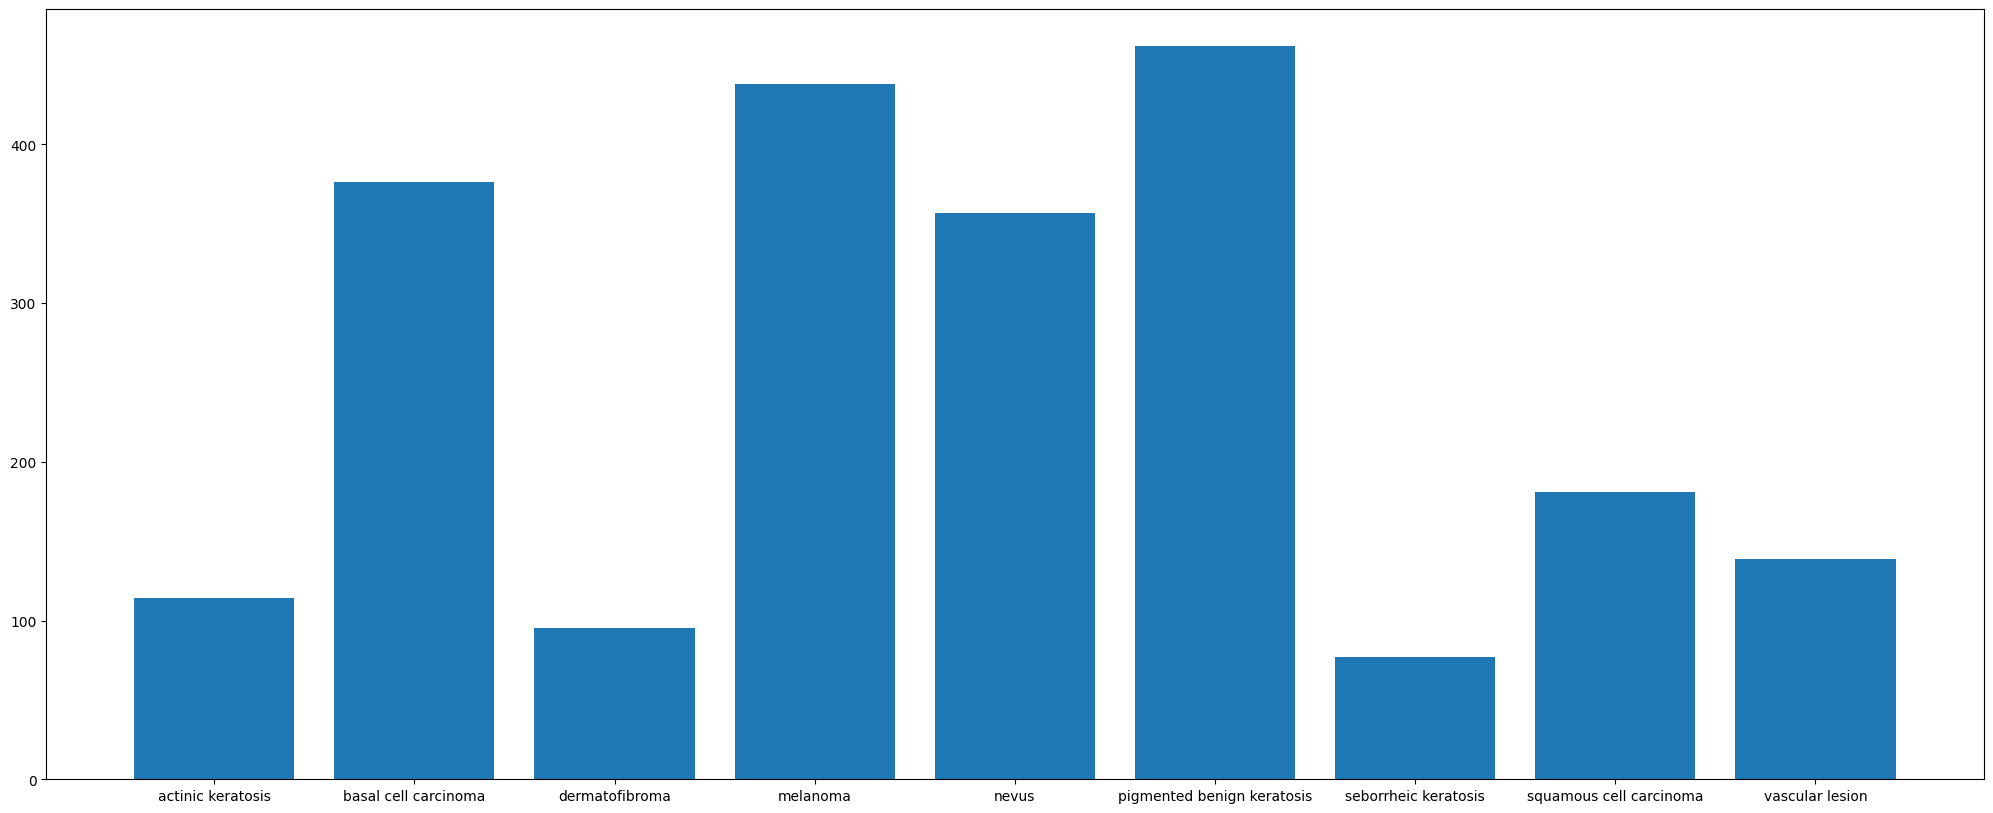

In [26]:
class_count=[]
for i in class_names:
    class_count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,class_count)

Write your findings:
- Which class has the least number of samples?
seborrheic keratosis

- Which classes dominate the data in terms proportionate number of samples?
The classes dominate in the data are:-
* pigmented benign
* melanoma
* basal cell carcinoma
* nevus

Rectify the class imbalance
Context: You can use a python package known as Augmentor to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

In [28]:
#connect to gdrive and mount it
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [29]:
path_to_training_dataset  = str(data_dir_train)+'/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability = 0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x788879FCA620>: 100%|██████████| 500/500 [00:29<00:00, 16.86 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78887D3EA800>: 100%|██████████| 500/500 [00:33<00:00, 14.86 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x788868277AC0>: 100%|██████████| 500/500 [00:26<00:00, 18.94 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7888682778B0>: 100%|██████████| 500/500 [02:14<00:00,  3.71 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x788868213A60>: 100%|██████████| 500/500 [01:37<00:00,  5.14 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x788879FE75B0>: 100%|██████████| 500/500 [00:25<00:00, 19.90 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7888682C8A00>: 100%|██████████| 500/500 [00:50<00:00,  9.90 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x788879FCB9A0>: 100%|██████████| 500/500 [00:25<00:00, 19.34 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x788879FE7E80>: 100%|██████████| 500/500 [00:26<00:00, 18.67 Samples/s]


In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images.

In [31]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024612.jpg_0df2eeaa-1f23-4156-ab06-1731d226e39e.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026018.jpg_66a91a0e-a0b2-48ab-9d50-d9537f0f0c03.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026142.jpg_24fb52b5-49ad-47b6-b2bf-bad2f4085e1e.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026634.jpg_0da5727c-2073-4c4d-8dc8-5b0a7d86d7bc.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Ski

In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [33]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [34]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)
new_df=pd.concat([original_df,df2])

In [35]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


Train the model on the data created using Augmentor

In [36]:
batch_size = 32
img_height = 180
img_width = 180

In [37]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  data_dir_train,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [38]:
## Create Validation Dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  data_dir_train,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Create New Model

In [39]:
num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

In [40]:
## Compile Model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
epochs = 30
## Your code goes here, use 50 epochs.
history30 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 66s 340ms/step - accuracy: 0.1384 - loss: 2.3913 - val_accuracy: 0.1826 - val_loss: 2.1284
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 85s 357ms/step - accuracy: 0.2866 - loss: 1.8900 - val_accuracy: 0.4432 - val_loss: 1.5123
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 71s 296ms/step - accuracy: 0.4183 - loss: 1.5310 - val_accuracy: 0.4774 - val_loss: 1.3727
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 279ms/step - accuracy: 0.4552 - loss: 1.4204 - val_accuracy: 0.4788 - val_loss: 1.3498
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 84s 291ms/step - accuracy: 0.4701 - loss: 1.3919 - val_accuracy: 0.5145 - val_loss: 1.2820
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 284ms/step - accuracy: 0.4929 - loss: 1.3355 - val_accuracy: 0.5085 - val_loss: 1.2629
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 48s 285ms/step - accuracy: 0.5147 - loss: 1.2907 - val_accuracy: 0.5026 - val_loss: 1.2572
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 84s 296ms/step - accuracy: 0.5287 - loss: 1

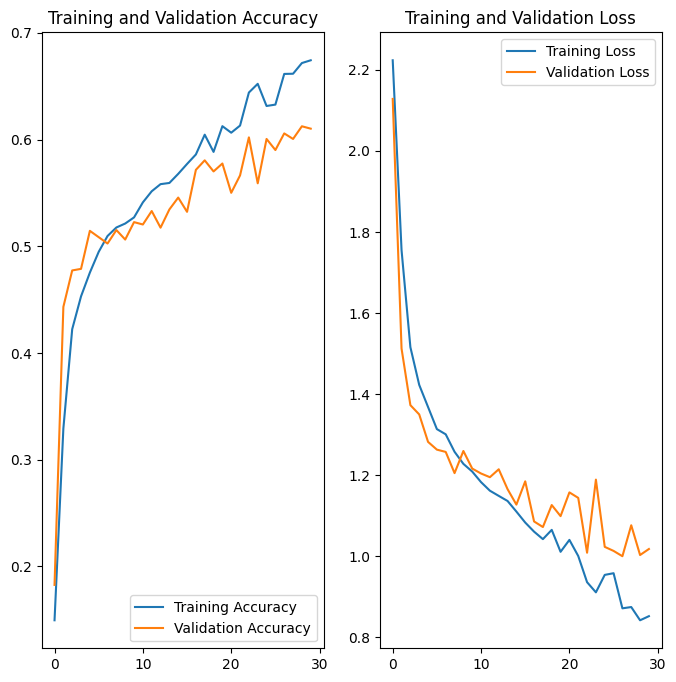

In [42]:
acc = history30.history['accuracy']
val_acc = history30.history['val_accuracy']

loss = history30.history['loss']
val_loss = history30.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The problem of overfitting and underfitting was solved and the model was well trained for predictions. Data augmentation improve model performance.

Analysis on Test Data

In [43]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed = 123,
    image_size = (img_height,img_width),
    batch_size = batch_size
)

Found 118 files belonging to 9 classes.


In [44]:
loss , accuracy = model.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 44s 10s/step - accuracy: 0.4203 - loss: 3.4953


In [45]:
print("Accuracy on test data ", accuracy)

Accuracy on test data  0.41525423526763916


In [50]:
melanoma_path = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/melanoma/ISIC_0000013.jpg")

img = tf.keras.utils.load_img(
    melanoma_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
tf.Tensor(
[2.1215799e-21 1.6175433e-15 1.9867454e-15 5.3228334e-02 9.4676757e-01
 4.0597101e-06 2.0857625e-09 5.8224394e-16 1.1252134e-11], shape=(9,), dtype=float32)


In [51]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(test_ds.class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to nevus with a 94.68 percent confidence.
